<a href="https://colab.research.google.com/github/ibrahin2024/PROYECTO_Clasificador_Prendas_de_Vestir.ipynb/blob/main/PROYECTO_Clasificador_Prendas_de_Vestir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Script completo: detecta carpetas, filtra imágenes corruptas, guarda métricas en CSV
# ==========================================================
import os
import shutil
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
import pandas as pd

# --------------------------
# CONFIG
# --------------------------
# Etiquetas fijas que quieres usar (orden obligatorio)
CLASES = ["pantalon", "camisa", "calcetin"]

# Límite por clase al balancear (ajusta si quieres)
LIMITE_POR_CLASE = 600

# Carpeta raíz donde buscar las carpetas originales (puede ser '/content' en Colab)
ROOT = "."  # ajusta si tus carpetas/ZIP están en otro lugar

In [6]:
# ---------- EXTRAER ZIPs AUTOMÁTICAMENTE (INSERTAR ANTES DE LA DETECCIÓN) ----------
import zipfile
import glob

ROOT = "."  # o '/content' en Colab

def extract_zip_if_needed(zip_path, target_folder):
    """
    Extrae zip_path dentro de target_folder si target_folder está vacío o no existe.
    Si ya existe y tiene archivos, no hace nada.
    """
    os.makedirs(target_folder, exist_ok=True)
    # si ya hay archivos en target_folder, asumimos que ya está extraído
    if any(os.scandir(target_folder)):
        print(f"Saltando extracción: '{target_folder}' ya tiene archivos.")
        return
    if not zipfile.is_zipfile(zip_path):
        print(f"No es zip válido: {zip_path}")
        return
    print(f"Extrayendo {zip_path} -> {target_folder} ...")
    with zipfile.ZipFile(zip_path, 'r') as zf:
        try:
            zf.extractall(path=target_folder)
            print("  Extracción completada.")
        except Exception as e:
            print(f"  Error extrayendo {zip_path}: {e}")

# Preferencia: buscar zips con nombres esperados (pantalones, camisas, calcetines)
expected_zips = {
    "pantalones": os.path.join(ROOT, "pantalones.zip"),
    "camisas":    os.path.join(ROOT, "camisas.zip"),
    "calcetines": os.path.join(ROOT, "calcetines.zip"),
}

# Extraer los zips esperados si existen
for folder_name, zip_path in expected_zips.items():
    if os.path.isfile(zip_path):
        target = os.path.join(ROOT, folder_name)
        extract_zip_if_needed(zip_path, target)

# Si alguno de los esperados no existe, busca cualquier .zip en ROOT y extrae
all_zips = glob.glob(os.path.join(ROOT, "*.zip"))
# filtrar los ya manejados
remaining_zips = [z for z in all_zips if os.path.basename(z) not in (os.path.basename(p) for p in expected_zips.values())]
if remaining_zips:
    print("\nZips adicionales encontrados en ROOT (se extraen a carpetas con el nombre del zip sin .zip):")
    for z in remaining_zips:
        base = os.path.splitext(os.path.basename(z))[0]
        target = os.path.join(ROOT, base)
        extract_zip_if_needed(z, target)

# También puede haber zips dentro subcarpetas: opcionalmente puedes extraerlos recursivamente
# Si quieres extracción recursiva, descomenta lo siguiente:
# for z in glob.glob(os.path.join(ROOT, "**", "*.zip"), recursive=True):
#     base = os.path.splitext(os.path.basename(z))[0]
#     target = os.path.join(ROOT, base)
#     extract_zip_if_needed(z, target)

print("\nProceso de extracción finalizado. Ahora continúa con la detección de carpetas.")
# -----------------------------------------------------------------------------------

Extrayendo ./pantalones.zip -> ./pantalones ...
  Extracción completada.
Extrayendo ./camisas.zip -> ./camisas ...
  Extracción completada.
Extrayendo ./calcetines.zip -> ./calcetines ...
  Extracción completada.

Proceso de extracción finalizado. Ahora continúa con la detección de carpetas.


In [7]:
# --------------------------
# 1) Detectar carpetas fuente y mapear a nuestras clases
# --------------------------
# Preferencia: usar carpetas con nombre exacto si existen.
expected_dirs = ["pantalones", "camisas", "calcetines"]
found = {}

for d in expected_dirs:
    path = os.path.join(ROOT, d)
    if os.path.isdir(path):
        found[d] = path

if len(found) == 3:
    print("Encontradas las 3 carpetas esperadas:", ", ".join(found.keys()))
    source_map = {
        "pantalon": found["pantalones"],
        "camisa": found["camisas"],
        "calcetin": found["calcetines"]
    }
else:
    # Si no existen las tres carpetas exactas, detectamos primeras 3 subcarpetas en ROOT
    subdirs = [d for d in os.listdir(ROOT) if os.path.isdir(os.path.join(ROOT, d))]
    # Excluir carpetas del dataset previo si las hubiera
    subdirs = [d for d in subdirs if d not in ("dataset", "modelo_tfjs", "__pycache__")]
    if len(subdirs) < 3:
        raise RuntimeError(f"No hay suficientes carpetas fuente en '{ROOT}'. Se requieren 3 (pantalones, camisas, calcetines) o al menos 3 subcarpetas.")
    # Tomamos las primeras 3 y las mapeamos en orden a las clases pedidas
    mapping_sources = subdirs[:3]
    print("No se encontraron las carpetas exactas. Se usarán estas carpetas y se mapearán a las clases:")
    for cls, src in zip(CLASES, mapping_sources):
        print(f"  {src}  -->  {cls}")
    source_map = {
        "pantalon": os.path.join(ROOT, mapping_sources[0]),
        "camisa": os.path.join(ROOT, mapping_sources[1]),
        "calcetin": os.path.join(ROOT, mapping_sources[2]),
    }

# Normalizamos: asumimos que dentro de cada fuente puede haber una estructura anidada
def guess_image_folder(src_folder):
    """Devuelve la carpeta que contiene imágenes: si hay una subcarpeta con mismo nombre repite,
       si no, devuelve la propia."""
    base = os.path.basename(src_folder.rstrip("/"))
    candidate = os.path.join(src_folder, base, base)
    if os.path.isdir(candidate):
        return candidate
    candidate2 = os.path.join(src_folder, base)
    if os.path.isdir(candidate2):
        return candidate2
    # Si no hay subcarpetas, asumimos que las imágenes están en src_folder
    return src_folder

for k in list(source_map.keys()):
    source_map[k] = guess_image_folder(source_map[k])

print("\nCarpetas finales que se usarán como fuentes de imagen:")
for cls in CLASES:
    print(f"  {cls}: {source_map[cls]}")


Encontradas las 3 carpetas esperadas: pantalones, camisas, calcetines

Carpetas finales que se usarán como fuentes de imagen:
  pantalon: ./pantalones/pantalones
  camisa: ./camisas/camisas
  calcetin: ./calcetines/calcetines


In [8]:
# --------------------------
# 2) Crear carpetas destino (dataset) y copiar imágenes válidas (sin corruptas)
# --------------------------
os.makedirs("dataset", exist_ok=True)
for cls in CLASES:
    dest = os.path.join("dataset", cls, cls)
    os.makedirs(dest, exist_ok=True)

def is_valid_image(path):
    try:
        with Image.open(path) as im:
            im.verify()  # verifica integridad
        return True
    except (UnidentifiedImageError, OSError, IOError):
        return False

def copiar_imagenes_validas(src_folder, dest_folder, limite=LIMITE_POR_CLASE):
    archivos = sorted(os.listdir(src_folder))
    cont = 0
    skipped = 0
    for nombre in archivos:
        ruta = os.path.join(src_folder, nombre)
        if os.path.isfile(ruta):
            if cont >= limite:
                break
            if is_valid_image(ruta):
                try:
                    shutil.copy(ruta, os.path.join(dest_folder, nombre))
                    cont += 1
                except Exception as e:
                    skipped += 1
                    print(f"  Error copiando {ruta}: {e}")
            else:
                skipped += 1
    return cont, skipped

copied_counts = {}
for cls in CLASES:
    src = source_map[cls]
    dest = os.path.join("dataset", cls, cls)
    print(f"\nCopiando imágenes válidas de '{src}'  -->  '{dest}' (límite {LIMITE_POR_CLASE})")
    n_copied, n_skipped = copiar_imagenes_validas(src, dest, limite=LIMITE_POR_CLASE)
    copied_counts[cls] = n_copied
    print(f"  Copiadas: {n_copied}, Omitidas/Erróneas: {n_skipped}")

print("\nConteo final en dataset:")
for cls in CLASES:
    n = len(os.listdir(os.path.join("dataset", cls, cls)))
    print(f"  {cls}: {n}")


Copiando imágenes válidas de './pantalones/pantalones'  -->  'dataset/pantalon/pantalon' (límite 600)
  Copiadas: 262, Omitidas/Erróneas: 0

Copiando imágenes válidas de './camisas/camisas'  -->  'dataset/camisa/camisa' (límite 600)
  Copiadas: 310, Omitidas/Erróneas: 0

Copiando imágenes válidas de './calcetines/calcetines'  -->  'dataset/calcetin/calcetin' (límite 600)
  Copiadas: 273, Omitidas/Erróneas: 0

Conteo final en dataset:
  pantalon: 262
  camisa: 310
  calcetin: 273


In [9]:
# --------------------------
# 3) Aumentos, flow_from_directory
# --------------------------
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=15,
    zoom_range=[0.5,1.5],
    validation_split=0.2
)

data_gen_entrenamiento = datagen.flow_from_directory(
    "dataset",
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    subset="training"
)

data_gen_pruebas = datagen.flow_from_directory(
    "dataset",
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    subset="validation"
)

Found 677 images belonging to 3 classes.
Found 168 images belonging to 3 classes.



Mostrando primeras imágenes de pantalon


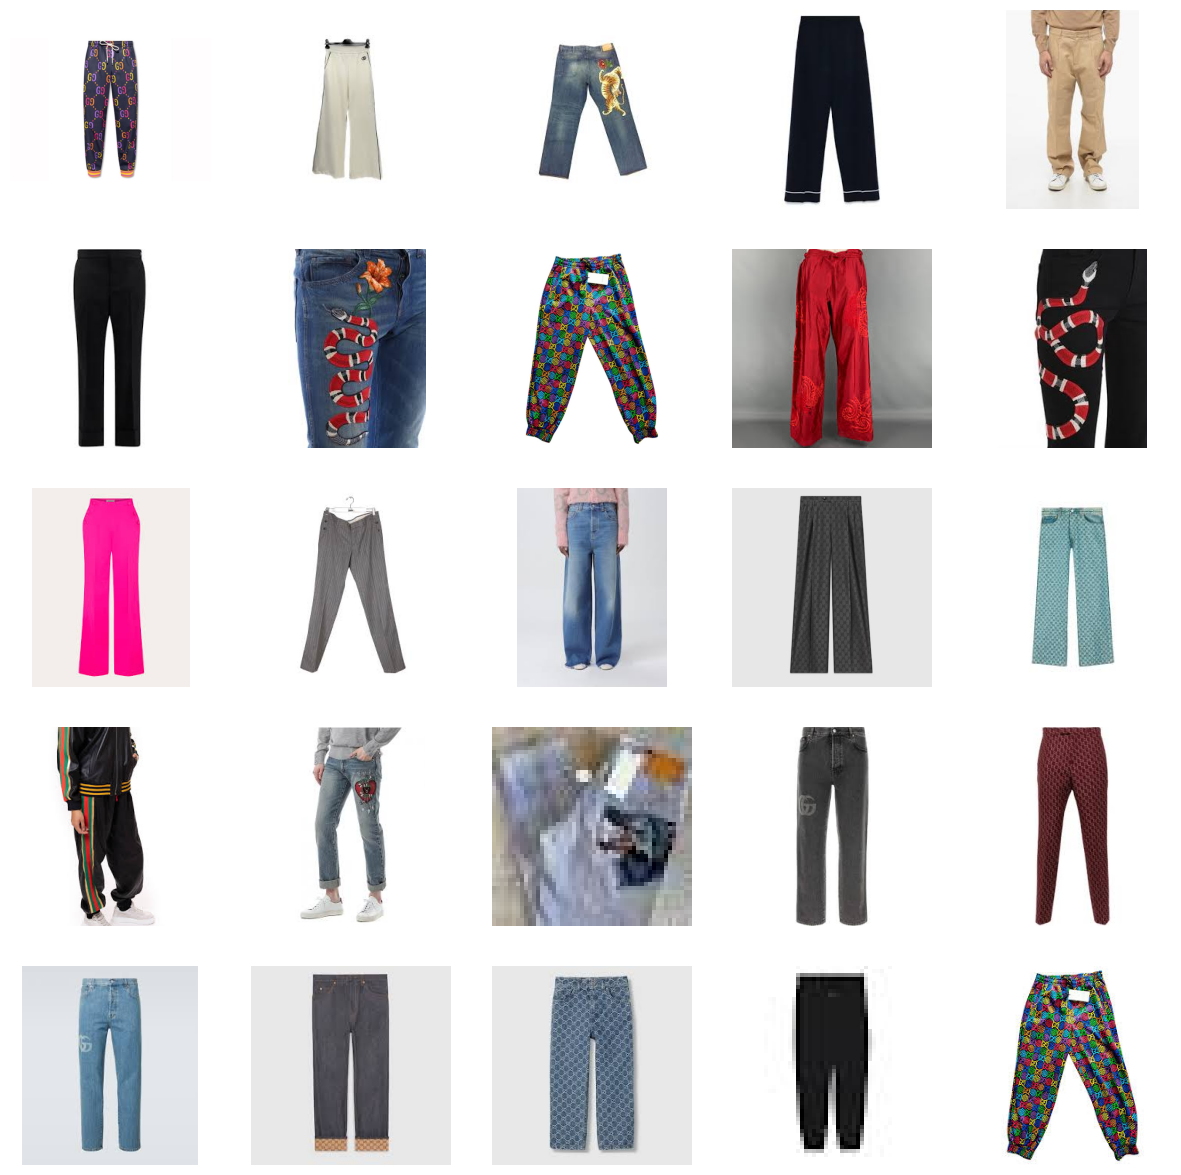


Mostrando primeras imágenes de camisa


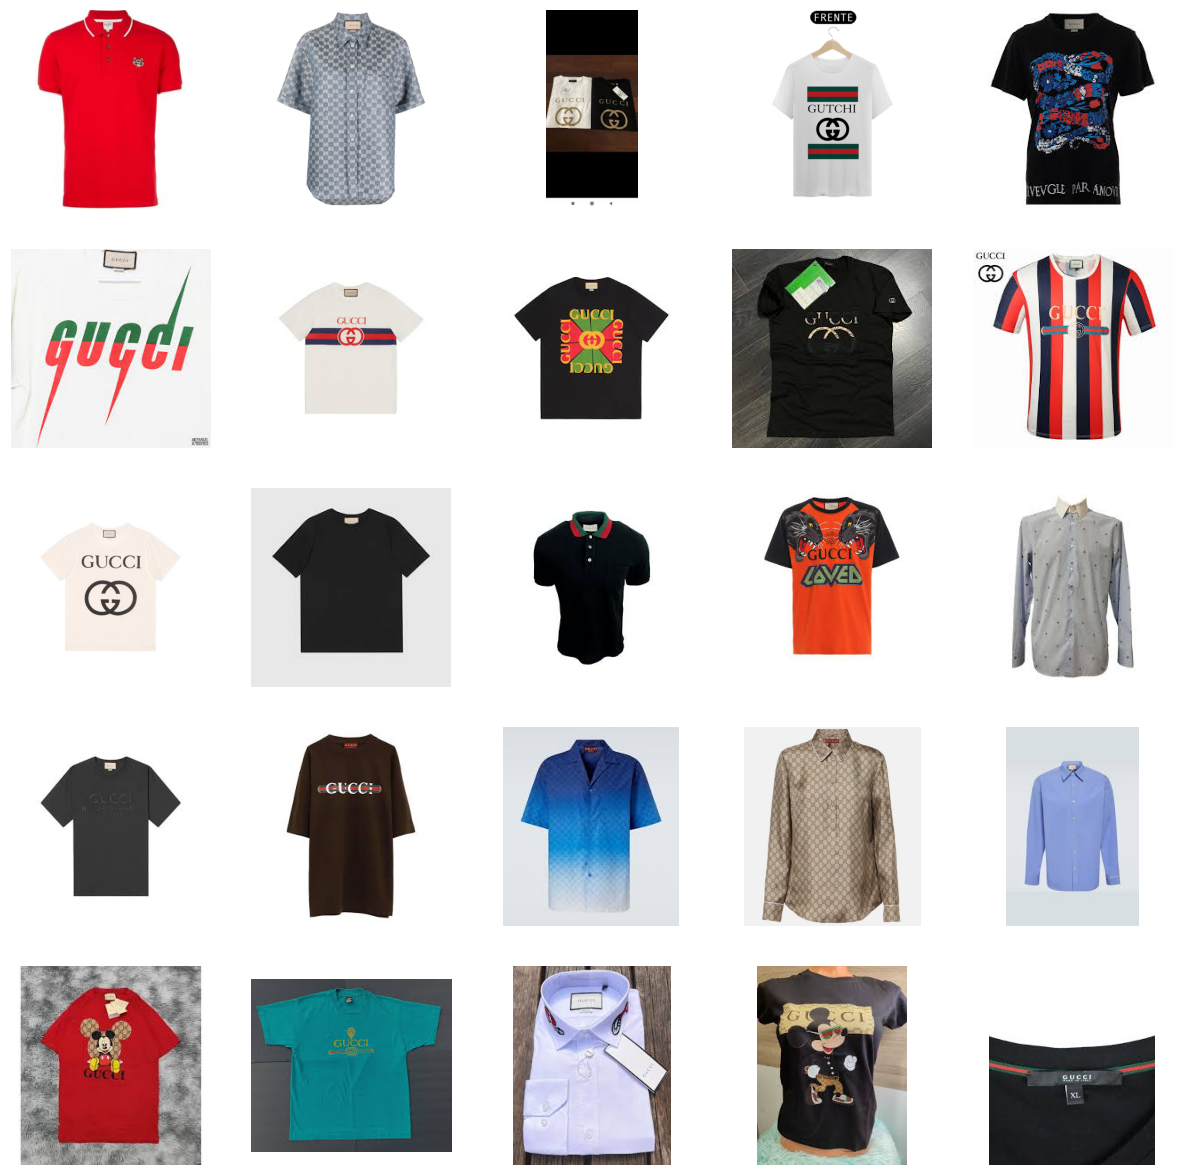


Mostrando primeras imágenes de calcetin


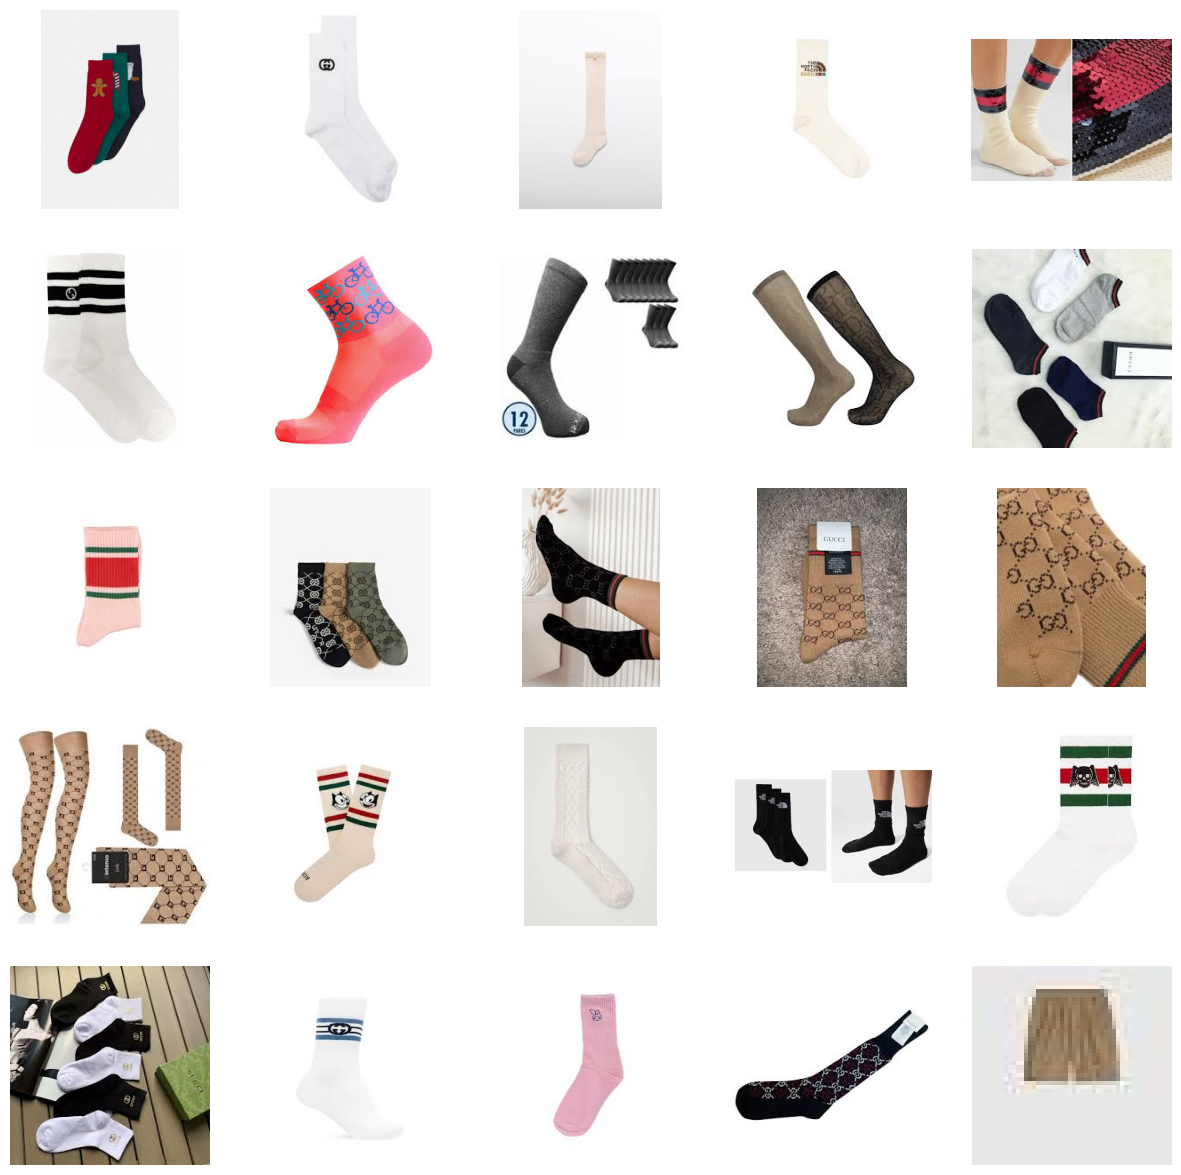

In [10]:
# --------------------------
# 4) Visualizar algunos ejemplos (maneja posibles errores al abrir)
# --------------------------
def mostrar_imagenes(carpeta):
    archivos = os.listdir(carpeta)
    plt.figure(figsize=(15,15))
    mostradas = 0
    for nombreimg in archivos:
        if mostradas >= 25:
            break
        ruta = os.path.join(carpeta, nombreimg)
        try:
            img = mpimg.imread(ruta)
            plt.subplot(5,5,mostradas+1)
            plt.imshow(img)
            plt.axis("off")
            mostradas += 1
        except Exception:
            continue
    plt.show()

# Mostrar por clase (si hay imágenes)
for cls in CLASES:
    carpeta = os.path.join("dataset", cls, cls)
    if os.path.isdir(carpeta) and len(os.listdir(carpeta))>0:
        print(f"\nMostrando primeras imágenes de {cls}")
        mostrar_imagenes(carpeta)
    else:
        print(f"\nNo hay imágenes para mostrar en {cls} (carpeta vacía o inexistente)")

In [11]:
# --------------------------
# 5) Modelo (como antes)
# --------------------------
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
    pooling="avg"
)

base_model.trainable = False  # Congelar pesos

inputs = tf.keras.Input(shape=(224,224,3))
x = base_model(inputs)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(len(CLASES), activation="softmax")(x)

modelo = tf.keras.Model(inputs, outputs)

modelo.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

modelo.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# --------------------------
# 6) Entrenamiento
# --------------------------
EPOCAS = 50

historial = modelo.fit(
    data_gen_entrenamiento,
    epochs=EPOCAS,
    validation_data=data_gen_pruebas
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.4978 - loss: 1.0795

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5013 - loss: 1.0718 - val_accuracy: 0.8512 - val_loss: 0.4608
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 514ms/step - accuracy: 0.7784 - loss: 0.5530 - val_accuracy: 0.8393 - val_loss: 0.3879
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 511ms/step - accuracy: 0.8250 - loss: 0.4540 - val_accuracy: 0.8869 - val_loss: 0.3219
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 580ms/step - accuracy: 0.8420 - loss: 0.4273 - val_accuracy: 0.9048 - val_loss: 0.2827
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 498ms/step - accuracy: 0.8782 - loss: 0.3122 - val_accuracy: 0.8988 - val_loss: 0.2890
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 468ms/step - accuracy: 0.8666 - loss: 0.3451 - val_accuracy: 0.9107 - val_loss: 0.2405
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 524ms/step - accuracy: 0.8577 - loss: 0.3451 - val_accuracy: 0.8690 - val_loss: 0.2994
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 514ms/step - accuracy: 0.8814 - loss: 0.2997 - val_accuracy: 0.8869 -

In [13]:
# --------------------------
# 7) Guardar métricas a CSV
# --------------------------
hist_df = pd.DataFrame(historial.history)
hist_df['epoch'] = hist_df.index + 1
cols = ['epoch', 'accuracy', 'val_accuracy', 'loss', 'val_loss']
hist_df.to_csv("metrics_historial.csv", columns=cols, index=False)
print("\n✅ Métricas guardadas en 'metrics_historial.csv'")

# Mostrar últimas métricas
print("\nÚltimas métricas guardadas:")
print(hist_df[cols].tail(1).T)


✅ Métricas guardadas en 'metrics_historial.csv'

Últimas métricas guardadas:
                     49
epoch         50.000000
accuracy       0.929099
val_accuracy   0.922619
loss           0.170641
val_loss       0.187921


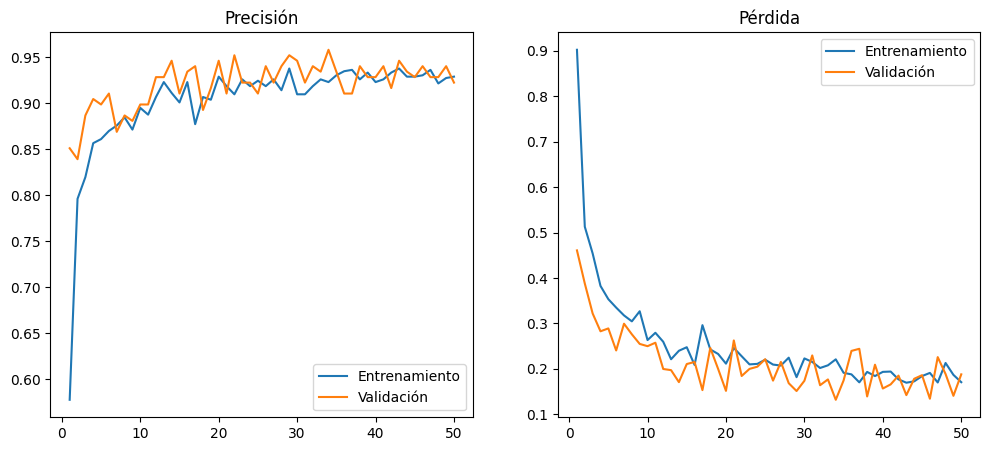

In [14]:
# --------------------------
# 8) Graficar (como antes)
# --------------------------
acc = historial.history.get("accuracy", [])
val_acc = historial.history.get("val_accuracy", [])
loss = historial.history.get("loss", [])
val_loss = historial.history.get("val_loss", [])
rango_epocas = range(1, len(acc)+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label="Entrenamiento")
plt.plot(rango_epocas, val_acc, label="Validación")
plt.title("Precisión")
plt.legend()

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label="Entrenamiento")
plt.plot(rango_epocas, val_loss, label="Validación")
plt.title("Pérdida")
plt.legend()
plt.show()

In [15]:
# --------------------------
# 9) Predicción online (manejo de errores)
# --------------------------
from io import BytesIO
import requests

def categorizar(url):
    try:
        resp = requests.get(url, timeout=10)
        resp.raise_for_status()
        img = Image.open(BytesIO(resp.content)).convert("RGB")
        img = img.resize((224,224))
        img_array = np.array(img)/255.0
        pred = modelo.predict(img_array.reshape(1,224,224,3))
        indice = np.argmax(pred[0])
        return CLASES[indice]
    except Exception as e:
        return f"ERROR al predecir: {e}"

# Ejemplo de uso (reemplaza por una URL válida)
# url = "https://ejemplo.com/imagen.jpg"
# print("Predicción:", categorizar(url))

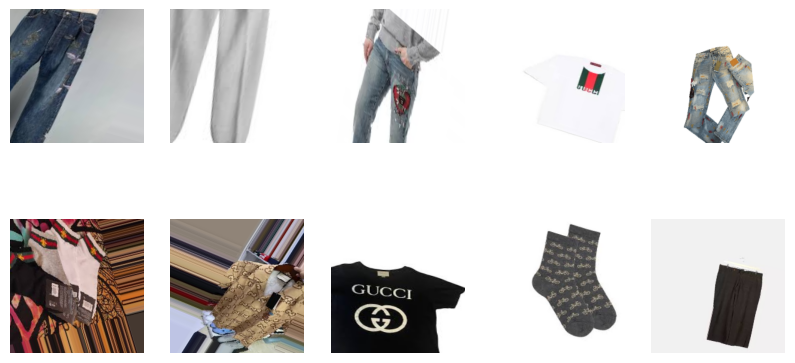

In [16]:
# ===========================
# 7️⃣ VISUALIZAR EJEMPLOS
# ===========================
import numpy as np

imagenes, etiquetas = next(data_gen_entrenamiento)
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(imagenes[i])
    plt.axis("off")
plt.show()

In [17]:
# --------------------------
# 10) Exportar a TF.js y guardar modelo Keras
# --------------------------
# Guardar en formato Keras nativo (recomendado)
modelo.save("modelo_final.keras")
print("Modelo guardado en formato Keras: modelo_final.keras")
!pip install tensorflowjs
# Exportar TF.js (requiere instalación de tensorflowjs)
try:
    import tensorflowjs as tfjs
    tfjs.converters.save_keras_model(modelo, "modelo_tfjs")
    print("✅ Modelo exportado para TensorFlow.js en la carpeta modelo_tfjs/")
except Exception as e:
    print("No se pudo exportar a TF.js (falta la librería o problema):", e)

# FIN del script

Modelo guardado en formato Keras: modelo_final.keras
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.7.1 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.35.1 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


failed to lookup keras version from the file,
    this is likely a weight only file
✅ Modelo exportado para TensorFlow.js en la carpeta modelo_tfjs/
